- DIFFERENCE: tried another cv strategy  
  
- VER1:alpha=0.1
- VER2:alpha=5

# SCP Quickstart

This notebook shows how to cross-validate a model for the *Open Problems – Single-Cell Perturbations* competition.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import StratifiedKFold

# Reading the data

In [3]:
id_map = pd.read_csv('data/id_map.csv',
                     index_col='id')

de_train = pd.read_parquet('data/de_train.parquet')
genes = de_train.columns[5:] # 18211 genes
de_train

,cell_type,sm_name,sm_lincs_id,SMILES,control,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
0,NK cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.104720,-0.077524,-1.625596,-0.144545,0.143555,...,-0.227781,-0.010752,-0.023881,0.674536,-0.453068,0.005164,-0.094959,0.034127,0.221377,0.368755
1,T cells CD4+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.915953,-0.884380,0.371834,-0.081677,-0.498266,...,-0.494985,-0.303419,0.304955,-0.333905,-0.315516,-0.369626,-0.095079,0.704780,1.096702,-0.869887
2,T cells CD8+,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,-0.387721,-0.305378,0.567777,0.303895,-0.022653,...,-0.119422,-0.033608,-0.153123,0.183597,-0.555678,-1.494789,-0.213550,0.415768,0.078439,-0.259365
3,T regulatory cells,Clotrimazole,LSM-5341,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,False,0.232893,0.129029,0.336897,0.486946,0.767661,...,0.451679,0.704643,0.015468,-0.103868,0.865027,0.189114,0.224700,-0.048233,0.216139,-0.085024
4,NK cells,Mometasone Furoate,LSM-3349,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,False,4.290652,-0.063864,-0.017443,-0.541154,0.570982,...,0.758474,0.510762,0.607401,-0.123059,0.214366,0.487838,-0.819775,0.112365,-0.122193,0.676629
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,T regulatory cells,Atorvastatin,LSM-5771,CC(C)c1c(C(=O)Nc2ccccc2)c(-c2ccccc2)c(-c2ccc(F...,False,-0.014372,-0.122464,-0.456366,-0.147894,-0.545382,...,-0.549987,-2.200925,0.359806,1.073983,0.356939,-0.029603,-0.528817,0.105138,0.491015,-0.979951
610,NK cells,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,-0.455549,0.188181,0.595734,-0.100299,0.786192,...,-1.236905,0.003854,-0.197569,-0.175307,0.101391,1.028394,0.034144,-0.231642,1.023994,-0.064760
611,T cells CD4+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.338168,-0.109079,0.270182,-0.436586,-0.069476,...,0.077579,-1.101637,0.457201,0.535184,-0.198404,-0.005004,0.552810,-0.209077,0.389751,-0.337082
612,T cells CD8+,Riociguat,LSM-45758,COC(=O)N(C)c1c(N)nc(-c2nn(Cc3ccccc3F)c3ncccc23...,False,0.101138,-0.409724,-0.606292,-0.071300,-0.001789,...,0.005951,-0.893093,-1.003029,-0.080367,-0.076604,0.024849,0.012862,-0.029684,0.005506,-1.733112


# Cross-validation

We can see this competition as a multi-output regression task with 18211 targets and only two features (cell_type and sm_name). Both features are categorical.

The diagram shows in red which combinations of the two categorical features (cell_type, sm_name) are in the test set.

**Insight:**
- We want to predict the 18211 differential gene expressions for unseen (cell_type, sm_name) combinations. Cross-validation must simulate this setting. A possible cross-validation strategy makes four folds, of which the diagram shows the first fold in blue.


In [4]:
B_M_df = de_train[de_train["cell_type"].isin(["B cells", "Myeloid cells"])].reset_index(drop=True)
mean_score = B_M_df[["sm_name"]+genes.tolist()].groupby("sm_name").agg("mean").mean(axis=1)
classes = np.digitize(mean_score.values, bins=[0.1, 0.5, 1])
cpds = mean_score.index.values
fold_arr = np.full(len(cpds), -1)
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for fold, (trn_ind, val_ind) in enumerate(skf.split(classes, classes)):
    fold_arr[val_ind] = fold
fold_map = {c: f for c, f in zip(cpds, fold_arr)}
fold_to_cpds = {fold: cpds[fold_arr==fold] for fold in range(3)}

fold_to_cpds

{0: array(['Alvocidib', 'Belinostat', 'Foretinib', 'LDN 193189',
        'Linagliptin', 'O-Demethylated Adapalene'], dtype=object),
 1: array(['Dabrafenib', 'Dactolisib', 'Idelalisib', 'MLN 2238',
        'Palbociclib', 'Porcn Inhibitor III'], dtype=object),
 2: array(['CHIR-99021', 'Crizotinib', 'Oprozomib (ONX 0912)', 'Penfluridol',
        'R428'], dtype=object)}

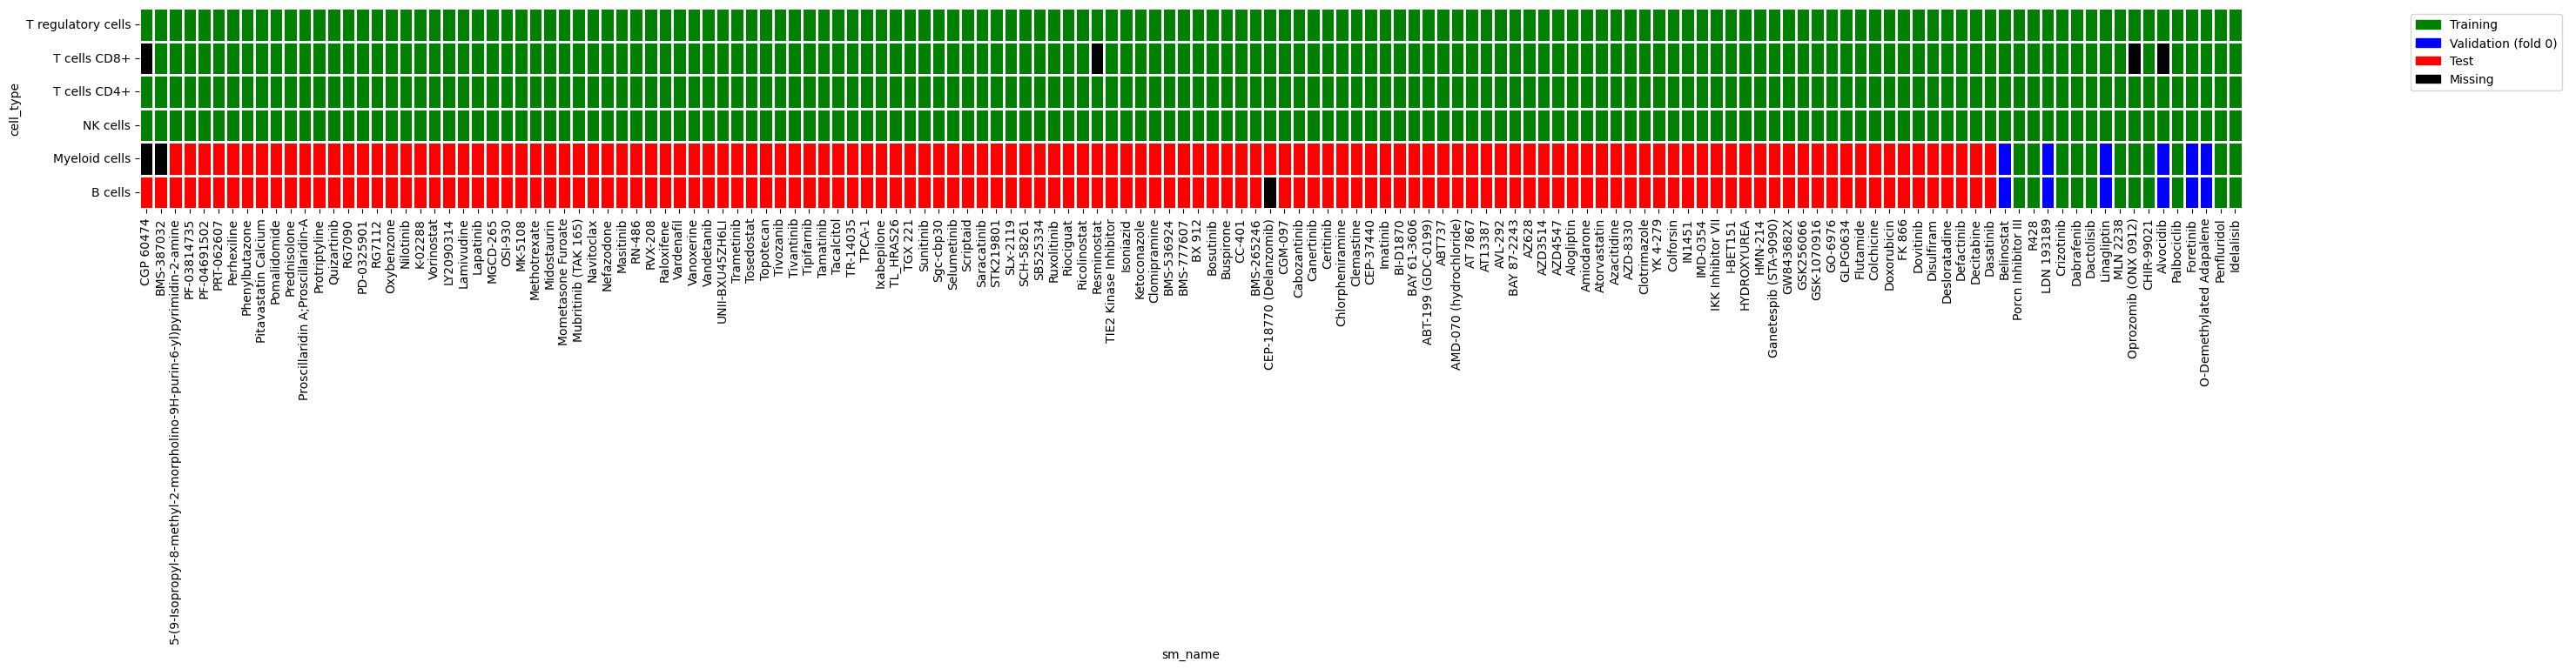

In [5]:
def plot_cv_diagram(fold, fold_to_cpds):
    cv_diagram = pd.concat([de_train[['cell_type', 'sm_name']],
                            id_map[['cell_type', 'sm_name']]], axis=0, keys=[2,1])
    cv_diagram = cv_diagram.reset_index().drop(columns=['level_1'])
    cv_diagram = cv_diagram.pivot(index='cell_type', columns='sm_name')
    cv_diagram.fillna(0, inplace=True)
    cv_diagram = cv_diagram.droplevel(level=0, axis=1)
    cv_diagram = cv_diagram.sort_values('Myeloid cells', axis=1)
    cv_diagram = cv_diagram.sort_index(ascending=False)
#     cv_diagram.loc[val_cell_type] *= 1 + (cv_diagram.loc[['Myeloid cells', 'B cells']] == 1).any().astype(float) * 0.5
    cpds_fold = fold_to_cpds[fold].tolist()
    cv_diagram.loc[['Myeloid cells', 'B cells'], cpds_fold] = 3
    # 0=Missing
    # 1=Test
    # 2=Training
    # 3=Validation
    _, (ax1, ax2) = plt.subplots(1, 2, width_ratios=(20, 1), figsize=(36, 3))
    sns.heatmap(cv_diagram, cbar=False, linewidths=1, ax=ax1, cmap=['k', 'r', 'g', 'b'])
    
    ax2.legend(handles=[mpatches.Patch(color='g', label='Training'),
                        mpatches.Patch(color='b', label=f'Validation (fold {fold})'),
                        mpatches.Patch(color='r', label='Test'),
                        mpatches.Patch(color='k', label='Missing')])
    ax2.axis('off')
    plt.show()
    
plot_cv_diagram(0, fold_to_cpds)
# fold_to_cpds
# plot_cv_diagram('T cells CD8+')

Our model is simple:
- We denoise the targets by applying a singular value decomposition. As a consequence of this transformation, we must inverse-tranform the predictions.
- We use sm_name as our unique feature, one-hot encode it and then use ridge regression to predict the transformed targets.
- The two hyperparameters `n_components` and `alpha` were tuned for the best cross-validation score.


In [6]:
temp = de_train.groupby(['cell_type']).size() > 20
validation_cell_types = temp[temp].index # 4 cell types

train_sm_names = de_train.query("cell_type == 'B cells'").sm_name.values # 17 compounds including the two control compounds

features = ['cell_type', 'sm_name']

def cross_val_svd(model, label, n_components=5, print_each=False):
    mrrmse_list = []
    for fold in range(3):
#         mask_va = (de_train.cell_type == val_cell_type) & ~de_train.sm_name.isin(train_sm_names)
        mask_va = de_train['cell_type'].isin(['Myeloid cells', 'B cells']) & de_train['sm_name'].isin(fold_to_cpds[fold])
        mask_tr = ~mask_va # 485 or 487 training rows
        
        train = de_train[mask_tr]
        val = de_train[mask_va]
        y_true = val[genes]
        
        svd = TruncatedSVD(n_components=n_components, random_state=1)
        z_tr = svd.fit_transform(train[genes])
        
        model.fit(train[features], z_tr)
        y_pred = svd.inverse_transform(model.predict(val[features]))
        
        mrrmse = np.sqrt(np.square(y_true - y_pred).mean(axis=1)).mean()
        if print_each:
#             print(f"# Fold {fold}: {mrrmse:5.3f} val='{val_cell_type}'")
            print(f"# Fold {fold}: {mrrmse:5.3f}")
        mrrmse_list.append(mrrmse)
    mrrmse = np.array(mrrmse_list).mean()
    print(f"# Overall {mrrmse:5.3f} {label}")
    return mrrmse

All trials = [(0.1, ('sm_name',)), (0.1, ('cell_type',)), (0.1, ('sm_name', 'cell_type')), (1, ('sm_name',)), (1, ('cell_type',)), (1, ('sm_name', 'cell_type')), (5, ('sm_name',)), (5, ('cell_type',)), (5, ('sm_name', 'cell_type'))]
# Overall 2.694 svd n_comps=10 ridge alpha=0.1
# Overall 3.610 svd n_comps=10 ridge alpha=0.1
# Overall 2.969 svd n_comps=10 ridge alpha=0.1
# Overall 2.700 svd n_comps=10 ridge alpha=1
# Overall 3.537 svd n_comps=10 ridge alpha=1
# Overall 2.881 svd n_comps=10 ridge alpha=1
# Overall 2.872 svd n_comps=10 ridge alpha=5
# Overall 3.336 svd n_comps=10 ridge alpha=5
# Overall 2.899 svd n_comps=10 ridge alpha=5
# Overall 2.682 svd n_comps=20 ridge alpha=0.1
# Overall 3.614 svd n_comps=20 ridge alpha=0.1
# Overall 2.967 svd n_comps=20 ridge alpha=0.1
# Overall 2.688 svd n_comps=20 ridge alpha=1
# Overall 3.540 svd n_comps=20 ridge alpha=1
# Overall 2.877 svd n_comps=20 ridge alpha=1
# Overall 2.863 svd n_comps=20 ridge alpha=5
# Overall 3.336 svd n_comps=20 ridg

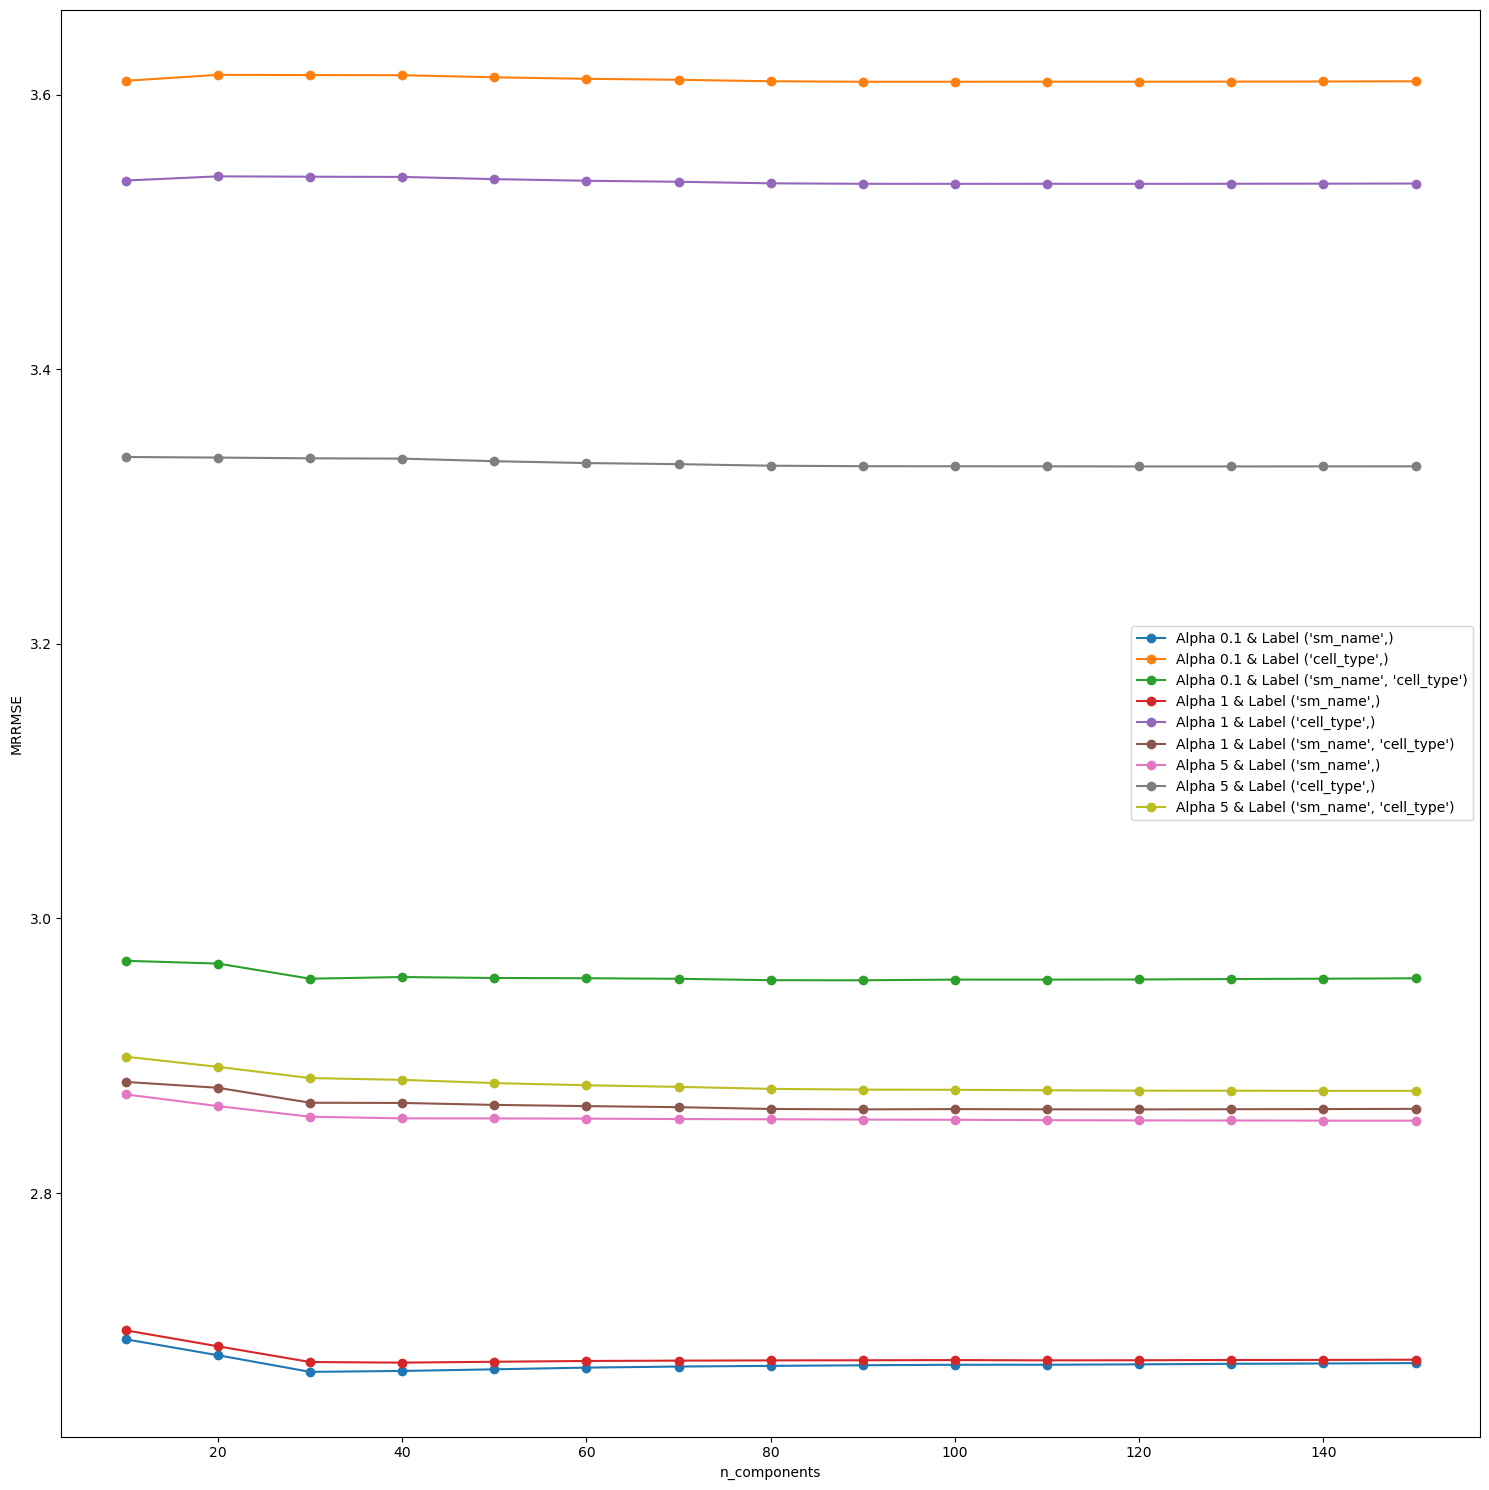

In [26]:
import itertools

alpha_list = [0.1, 1, 5] #10
labels = [('sm_name',),('cell_type',),('sm_name','cell_type')]
trials = list(itertools.product(alpha_list,labels))

print(f"All trials = {trials}")

n_comps_list = np.arange(10, 160, 30) # by 10
results = {trial: [] for trial in trials}
for n_comps in n_comps_list:
    for trial in trials:
        alpha,labels = trial
        model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(), list(labels))]),
                      Ridge(alpha=alpha, fit_intercept=False))
        mrrmse = cross_val_svd(model, f'svd {n_comps=} ridge {alpha=}',
                               n_components=n_comps)
        results[trial].append(mrrmse)

fig, ax = plt.subplots(figsize=(15,15))
for trial in trials:
    alpha,labels = trial
    ax.plot(n_comps_list, results[trial], "-o", label=f"Alpha {alpha} & Label {labels}")
ax.set_xlabel("n_components")
ax.set_ylabel("MRRMSE")
ax.legend()
fig.tight_layout()
plt.show()

In [8]:
n_components = 30
alpha = 5
model = make_pipeline(ColumnTransformer([('ohe', OneHotEncoder(), ['sm_name',"cell_type"])]),
                      Ridge(alpha=alpha, fit_intercept=False))
cross_val_svd(model, f'svd {n_components=} ridge {alpha=}',
              n_components=n_components, print_each=True)
# Fold 0: 1.089 val='NK cells'
# Fold 1: 0.971 val='T cells CD4+'
# Fold 2: 0.791 val='T cells CD8+'
# Fold 3: 1.008 val='T regulatory cells'
# Overall 0.965 svd n_components=100 ridge alpha=5

# Fold 0: 3.076
# Fold 1: 3.202
# Fold 2: 2.373
# Overall 2.884 svd n_components=30 ridge alpha=5


2.883745825351864

# Submission

We retrain the model on the full training data and create a submission file.

In [9]:
svd = TruncatedSVD(n_components=n_components, random_state=1)
z_tr = svd.fit_transform(de_train[genes])
model.fit(de_train[features], z_tr)
y_pred = svd.inverse_transform(model.predict(id_map[features]))


In [10]:
submission = pd.DataFrame(y_pred, columns=genes, index=id_map.index)
display(submission)
submission.to_csv('submission/quickstart_cv.csv')


,A1BG,A1BG-AS1,A2M,A2M-AS1,A2MP1,A4GALT,AAAS,AACS,AAGAB,AAK1,...,ZUP1,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1
id,,,,,,,,,,,,,,,,,,,,,
0,1.074238,0.201180,1.372204,1.824419,3.720343,2.135321,-0.038983,0.379597,0.174039,0.882656,...,0.079563,0.379818,0.288369,0.732195,0.763712,0.343181,0.514572,0.408007,0.073258,0.172313
1,0.879674,0.095981,1.046437,1.362042,3.300426,2.018889,0.008387,0.186690,0.356984,0.586206,...,0.259698,0.358156,0.226099,0.753700,0.477958,0.109330,0.270259,0.210907,0.164716,0.117732
2,1.003533,0.175392,1.092320,1.372856,3.424582,2.389281,0.015744,0.258773,0.340313,0.602421,...,0.252337,0.382596,0.268867,0.822348,0.598131,0.208535,0.319402,0.246825,0.151333,0.096010
3,0.880608,0.082147,1.088096,1.412168,3.325196,1.846360,-0.016475,0.186162,0.323311,0.659855,...,0.257312,0.347651,0.196268,0.717029,0.512528,0.135047,0.306826,0.235806,0.177865,0.110228
4,0.894443,0.064487,1.054678,1.415260,3.349828,1.948307,-0.052680,0.191562,0.266805,0.758781,...,0.181450,0.308072,0.193542,0.658118,0.505846,0.122780,0.316890,0.262323,0.173474,0.124008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.674243,0.272531,-2.754239,0.727047,4.129407,1.943735,0.162202,-0.098227,-0.115939,0.619243,...,-0.234433,-0.346272,-1.385916,-0.531306,0.857924,0.033541,-0.665962,-0.523487,-0.260092,-0.123536
251,0.805309,0.372224,-2.619965,0.870160,4.363509,2.308912,0.184845,-0.001939,-0.151138,0.656170,...,-0.247554,-0.270513,-1.290714,-0.398890,1.019615,0.153672,-0.591944,-0.467894,-0.232178,-0.122190
252,0.744739,0.328292,-2.671875,0.821957,4.271474,2.071070,0.183728,-0.024831,-0.128575,0.605784,...,-0.223449,-0.288746,-1.335680,-0.431924,0.956273,0.104665,-0.625319,-0.497067,-0.248585,-0.108635
